In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm, beta
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# Conformal Inference of Counterfactuals and Individual Treatment Effect

The covariate vector $X = (X_1, . . . , X_d)^T$ is such that $X_j = \Phi(X^\prime_j)$, where $\Phi$ denotes the cdf of the standard normal distribution and $(X_1^\prime, . . . , X_d^\prime)$ is an equicorrelated multivariate Gaussian vector with mean zero and $Var(X_j^\prime)$ = 1,
$Cov(X_j^\prime, X_{j^\prime}^\prime) = \rho$ for $j!= j^\prime$. When
$\rho = 0$, $X$ is uniformly distributed on the unit cube. When $\rho > 0$, the variables are positively
correlated

- The baseline potential outcome is such that Y(0) = 0. This simplifies the problem into a pure counterfactual inference problem.
- The potential outcome Y(1) is generated as follows:

    $$ E[Y(1) | X] = f(X_1)f(X_2), \quad f(x) = \frac{2}{1 + \exp\{-12(x - 0.5)\}}, $$

    which is the same as in Wager and Athey [2018], and

    $$ Y(1) = E[Y(1) | X] + \sigma(X)\varepsilon, \quad \varepsilon \sim N(0,1); $$

    the homoscedastic case $\sigma^2(x) \equiv \sigma^2$ is considered in Wager and Athey [2018];
- The propensity score $e(x)$ is set as:

    $$ e(x) = \frac{1}{4} \{1 + \beta_{2,4}(x_1)\}, $$

    where $\beta_{2,4}$ is the cdf of the beta distribution with shape parameters (2, 4). This ensures that $e(x) \in [0.25, 0.5]$, thereby providing sufficient overlap.

In our experiments, we will consider $8 = 2 \times 2 \times 2$ scenarios: low ($d = 10$) and high ($d = 100$) dimensions, uncorrelated ($\rho = 0$) and correlated ($\rho = 0.9$) covariates, and homoscedastic ($\sigma^2(x) \equiv 1$) and heteroscedastic ($\sigma^2(x) = -\log x_1$) errors.


In [38]:
def generate_data(nb_covariates, nb_samples, rho, sigma, seed=0):
    # generate equicorrelated miultivariate gaussian with zero mean and unit variance 
    cov = np.ones((nb_covariates, nb_covariates)) + rho 
    cov[np.diag_indices_from(cov)] = 1
    print(cov)
    X_prime = np.random.multivariate_normal(np.zeros(nb_covariates),cov, size=nb_samples)
    X = norm.cdf(X_prime)

    Y0 = np.zeros(nb_samples)
    fX1 = 2/(1+np.exp(-12*(X[:, 0]-0.5)))
    fX2 = 2/(1+np.exp(-12*(X[:, 1]-0.5)))
    cond_mean_Y1 = fX1 * fX2
    print(cond_mean_Y1.shape)
    Y1 = cond_mean_Y1 + np.random.normal(0, 1, nb_samples) * sigma

    # generate treatment following propencity score model
    T = np.random.binomial(1, propencity_score(X))

    return X, Y0, Y1, T

def propencity_score(x):
    beta_x1 = beta.cdf(x[:, 0], 2, 4)
    return 0.4 * (1+beta_x1)

In [39]:
nb_samples = 100
X, Y0, Y1, T  = generate_data(2, 100, 0.9, 10)

[[1.  1.9]
 [1.9 1. ]]
(100,)


covariance is not positive-semidefinite.


In [40]:
T

array([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [41]:
Yobs = Y0 * (1-T) + Y1 * T

In [42]:
Yobs

array([ 22.24821321, -13.99317745,   0.        ,   0.        ,
       -15.08490555,   0.        ,   0.        ,   5.73112608,
        12.26494078,   0.38008159,  -6.6718806 ,  -3.24437251,
       -15.42865402,   0.        ,   4.31958633,   0.        ,
       -18.02224347,   9.89933564,   9.85516316,   2.52614249,
        16.45532426,  -5.51279568,   0.        ,   8.0637824 ,
         0.        ,   0.        , -17.8169924 ,   0.        ,
        23.57927653,  -5.8743822 ,   0.        ,   0.        ,
         0.        ,   0.        ,   3.62680891,   3.35217313,
         0.        , -18.66164013,  -8.78708492,   0.        ,
         8.27417444,   0.        ,  10.11461752,  14.72087658,
        -5.56996576,   1.89765355,   3.45280408,   0.        ,
        -6.86341885,   2.02358765,   0.        ,   0.        ,
         9.58021052,   3.90948314,   7.58465222,   1.91449587,
        11.18143861,   0.        ,  11.7586354 ,   9.42803308,
         0.        ,   0.        ,   0.        ,   3.95

## CATE and variance CATE estimation 

In [43]:
import econml

# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV

from sklearn.linear_model import LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


### Causal Forest

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indexes = sss.split(X, T)
expected_te = Y1 - Y0

for index in indexes:
    train_index, test_index = index
    print(train_index, test_index)
    Xtrain, Xtest = X[train_index], X[test_index]
    Ttrain, Ttest = T[train_index], T[test_index]
    Yobstrain, Yobstest = Yobs[train_index], Yobs[test_index]
    expected_tetrain, expected_tetest = expected_te[train_index], expected_te[test_index]
    breaktrain, Xtest, Ytrain, Ytest, Ttrain, Ttest = train_test_split(X, Yobs, T, test_size=0.2, random_state=0)

causal_forest = CausalForestDML(model_y='auto', 
                       model_t='auto',
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       discrete_treatment=True,
                       random_state=123)
size_T = nb_samples*0.2
causal_forest.fit(Y=Yobstrain, T=Ttrain, X=Xtrain, cache_values=True)
treatment_effects = causal_forest.effect(Xtest)
te_lower, te_upper = causal_forest.effect_interval(Xtest)

[21 37 77 35 24 18 78 36 54 85 95 33 83 81 34 23 56 41 48 87 47 58  7 40
  4 97 42 57 73 11 76 45 68 28 26 27 92 25 22 43  9 91 62 90 15 67 65 84
 59 75 61 94 86 53 17  3 13 69 66 96  0  8 19 74 80 30 44 51 72 99 64 55
 50 12  5 10 89 70 71 31] [63  1 60 93 14  2 29 20 98 79 32 38 49 52 88 39 82 16  6 46]


In [45]:
treatment_effects

array([ 0.39139382, -0.03139684, -0.00239781,  0.29267971,  0.77984697,
        1.61963571,  1.87219813,  0.83578802,  0.29267971,  1.61963571,
        1.75381953,  0.76368043,  0.29267971,  1.61963571,  1.61963571,
        1.61963571,  0.54356567,  0.74083282,  1.24295997,  1.12450918])

In [46]:
causal_forest.summary()

Population summary of CATE predictions on Training Data


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate              
===============================================================
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.945       2.601 0.363  0.716        -4.152         6.042
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.571          -0.031           1.899
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       2.663         -4.309          6.673
        Doubly Robust ATE on Training Data Results       
=========================================================
    point_estimate stderr zstat  pvalue ci_lower ci_upper
---------------------------------------------------------
ATE         -5.528  9.126 -0.606  0.545  -23.414   12.358
    Doubly Robust ATT(T=0) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT        -22.435 29.911 -0.75  0.453  -81.059   36.189
    Doubly Robust ATT(T=1) on Training Data Results     
========================================================
    point_estimate stderr zstat pvalue ci_lower ci_upper
--------------------------------------------------------
ATT          1.718  1.583 1.085  0.278   -1.385    4.821
--------------------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

In [47]:
Ttrain

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [48]:
te_lower, te_upper

(array([-3.62124193, -4.3954934 , -4.33816195, -3.84378564, -1.98145168,
        -6.51189867, -0.7065182 , -2.63005258, -3.84378564, -6.51189867,
        -4.10062966, -3.18270393, -3.84378564, -6.51189867, -6.51189867,
        -6.51189867, -3.70018129, -3.39400505, -3.31479676, -6.37708388]),
 array([4.40402956, 4.33269972, 4.33336633, 4.42914506, 3.54114562,
        9.75117009, 4.45091447, 4.30162862, 4.42914506, 9.75117009,
        7.60826871, 4.71006479, 4.42914506, 9.75117009, 9.75117009,
        9.75117009, 4.78731263, 4.87567069, 5.80071671, 8.62610224]))

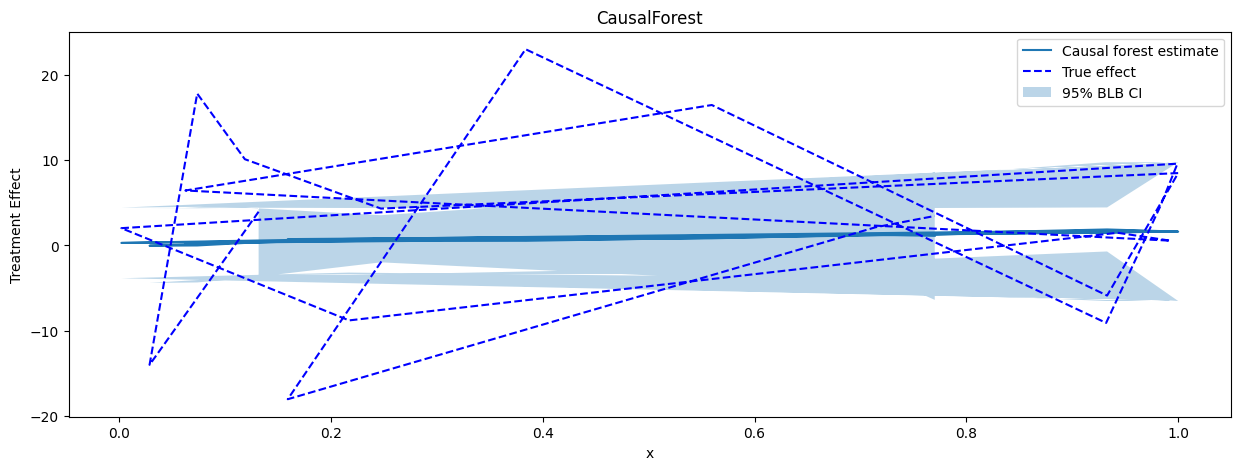

In [49]:
plt.figure(figsize=(15, 5))
plt.title("CausalForest")
plt.plot(Xtest[:, 0], treatment_effects, label='Causal forest estimate')
plt.plot(Xtest[:, 0], expected_tetest, 'b--', label='True effect')
plt.fill_between(Xtest[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()

### X-learner

### BART

# algorithm weighted splited CQR



In [1]:
def weighted_split_cqr(alpha, X, Y, T, x, quantile_reg, weigth_reg, inference_method="ate", interval="0"):
    """Compute the confidence interval of the ITE of x using the weighted split CQR method
    Args:
        alpha (int): confidence level
        X : covariates matrix of train, shape (nb_samples, nb_covariates)
        Y : outcome of train, shape (nb_samples,)
        T : treatment of train, shape (nb_samples,)
        x : covariates matrix of test, shape (nb_samples_test, nb_covariates)
        quantile_reg : quantile regressor
        weigth_reg : weight regressor

    Returns:
        interval : interval of confidence
    """
    Xtr, Xcal, Ytr, Ycal, Ttr, Tcal = train_test_split(X, Y, T, test_size=0.75, random_state=123)

    if inference_method == "ate":
        quantile_fit = quantile_reg.fit(Xtr, Ytr)
    elif inference_method == "att":
        #Xtr et Ytr de seulement où Ttr = 1
        quantile_fit = quantile_reg.fit(Xtr[Ttr == 1], Ytr[Ttr == 1])
    elif inference_method == "atc":
        #Xtr et Ytr de seulement où Ttr = 0
        quantile_fit = quantile_reg.fit(Xtr[Ttr == 0],  Ytr[Ttr == 0])
            
    weight_fit = weigth_reg.fit(Xtr, Ttr)

    q = quantile_fit.predict(Xcal)
    q_lo, q_hi = q[0], q[1]
    W = weight_fit.predict_proba(Xcal)[:, 1] # it's the propencity score e(Xcal)
    # need to convert in weight
    if interval == "1" and inference_method == "ate":
        W = 1/W # weight is the inverse of the propencity score
        w_hat = 1/(weight_fit.predict_proba(x)[:, 1]) # it's the weights of the test set
    elif interval == "0" and inference_method == "ate":
        W = 1/(1-W)
        w_hat = 1/(1 - weight_fit.predict_proba(x)[:, 1]) # it's the weights of the test set
    elif inference_method == "att" and interval == "0":
        W = W / (1-W)
        w_hat = weight_fit.predict_proba(x)[:, 1]/(1 - weight_fit.predict_proba(x)[:, 1]) # it's the weights of the test set
    elif inference_method == "att" and interval == "1":
        ValueError("Interval 1 is not available for ATT")
    elif inference_method == "atc" and interval == "1":
        W = (1-W)/W
        w_hat = (1 - weight_fit.predict_proba(x)[:, 1])/weight_fit.predict_proba(x)[:, 1] # it's the weights of the test set
    elif inference_method == "atc" and interval == "0":
        ValueError("Interval 0 is not available for ATC")

    V = np.max(np.array([q_lo-Ycal, Ycal-q_hi]), axis=0)
    # P will be a matrix of shape (len(Xcal), len(x))
    P = np.tile(W, (len(x),1))
    div = np.sum(W) + np.transpose(np.tile(w_hat, (len(Xcal),1)))
    P = P/div
    # test P is a matrix of shape (len(Xcal), len(x))
    Pinf = w_hat / (np.sum(W) + w_hat)
    # test Pinf is a vector of shape (len(x),)
    distribution = P * V 
    distribution = np.concatenate((distribution, np.expand_dims(Pinf, axis=1)), axis=1)
    eta = np.quantile(distribution, 1-alpha, axis=1)
    q2 = quantile_fit.predict(x)
    q_lo2, q_hi2 = q2[0], q2[1]
    I = [q_lo2 - eta, q_hi2 + eta]
    return I

# From Counterfactuals To Treatment Effects


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from quantile_forest import RandomForestQuantileRegressor

def tau(x1, x2, c1):
    return (0.228 +
            0.05 * (x1 < 0.07) -
            0.05 * (x2 < -0.69) -
            0.08 * np.isin(c1, [1, 13, 14]).astype(int))

def generate_synthetic_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.drop(columns=["schoolid"])
    Z1, Z2 = train_test_split(df, test_size=0.8, random_state=42)
    
    # Fit a random forest to predict E[Y(0)] using Z1
    rf_m0 = RandomForestRegressor(random_state=42)
    Z1_0 = Z1[Z1["Z"] == 0]
    Z1_1 = Z1[Z1["Z"] == 1]
    rf_m0.fit(Z1_0.drop(columns=["Y", "Z"]), Z1_0["Y"])
    
    # For generating synthetic covariate vectors X from Z2
    X_synthetic = Z2.sample(n=6000, replace=True, random_state=42).drop(columns=['Y', 'Z'])
    
    # Apply the learned model to predict E[Y(0)] for the synthetic data
    m0_hat = rf_m0.predict(X_synthetic)



    # Generate the treatment effect
    Cate = tau(X_synthetic["X1"], X_synthetic["X2"], X_synthetic["C1"])
    m1_hat = m0_hat + Cate

    # Quantile regression for Y(0) and Y(1)
    qrf_0 = RandomForestQuantileRegressor(random_state=42)
    qrf_1 = RandomForestQuantileRegressor(random_state=42)
    qrf_0.fit(Z1_0.drop(columns=["Y", "Z"]), Z1_0["Y"])
    qrf_1.fit(Z1_1.drop(columns=["Y", "Z"]), Z1_1["Y"])
    
    # Predict the quantiles for the synthetic data
    qrf_0_pred = qrf_0.predict(X_synthetic, quantiles=[0.25,0.75])
    qrf_1_pred = qrf_1.predict(X_synthetic, quantiles=[0.25,0.75])
    
    # Conditional interquartile range
    r_0 = qrf_0_pred[:, 1] - qrf_0_pred[:, 0]
    r_1 = qrf_1_pred[:, 1] - qrf_1_pred[:, 0]

    # Simulate Gaussian noise
    epsilon_1 = np.random.normal(0, 1, size=m1_hat.shape)
    epsilon_0 = np.random.normal(0, 1, size=m0_hat.shape)
    
    # Estimate the treatment effect
    Y_0_synthetic = m0_hat + 0.5 * r_0 * epsilon_0
    Y_1_synthetic = m1_hat + 0.5 * r_1 * epsilon_1

    # Generate the propensity score on Z1 using random forest
    propensity = RandomForestClassifier(random_state=42)
    propensity.fit(Z1.drop(columns=["Z", "Y"]), Z1["Z"])
    propensity_score = propensity.predict_proba(X_synthetic)[:, 1]
    
    # Clip the propensity score to guarantee overlap
    propensity_score = np.clip(propensity_score, 0.1, 0.9)
    
    # Generate treatment as a Bernoulli random variable of the propensity score
    treatment = np.random.binomial(1, propensity_score)
    
    # Construct the new data frame
    df_prop_treatment_Y = pd.DataFrame({'Y_0': Y_0_synthetic, "Y_1": Y_1_synthetic, 'Z': treatment})
    new_df = pd.concat([X_synthetic, df_prop_treatment_Y], axis=1)
    new_df["Y_obs"] = new_df["Y_0"] * (1 - new_df["Z"]) + new_df["Y_1"] * new_df["Z"]
    
    return new_df

# Example usage:
new_df = generate_synthetic_data("synthetic_data.csv")
print(new_df.head())


c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(


      S3  C1  C2  C3  XC        X1        X2        X3        X4        X5  \
9389   6   2   2   1   4  1.324323 -1.311438  1.930281  0.281143  0.362031   
5825   6   4   1   1   1 -0.617888 -0.163619 -0.991882 -0.946657  1.063790   
9016   5   4   2   0   1 -0.538975  1.433826 -0.033161 -0.982274  1.591641   
2028   5   1   1   1   3  1.406618 -1.289132  1.201728  0.584131 -0.235468   
4594   3   2   1   1   4  1.021777 -0.097336  0.225470 -0.805289 -0.329708   

           Y_0       Y_1  Z     Y_obs  
9389  0.523637  0.637794  0  0.523637  
5825 -0.351258 -0.140760  1 -0.140760  
9016 -0.081886  0.137286  1  0.137286  
2028 -0.040680  0.383440  0 -0.040680  
4594 -0.138724 -0.181358  0 -0.138724  


# Naive approch : Comparing Bart and weighted split-CQR algo 

In [3]:
from sklearn_quantile import RandomForestQuantileRegressor as RQRF
from quantile_forest import RandomForestQuantileRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# Assuming the RandomForestQuantileRegressor and GradientBoostingClassifier are correctly imported
# Also assuming the presence of weighted_split_cqr, tau functions and necessary data setup
def indicator(x, lower, upper):
    return (x >= lower) & (x <= upper)
def cate_marginal_coverage_estimate(te_lower, te_upper, cate_true):
    n = len(te_lower)
    cover_cate = np.mean(indicator(cate_true, te_lower, te_upper))
    return cover_cate

def ite_marginal_coverage_estimate(te_lower, te_upper, ite_true):
    n = len(te_lower)
    cover_ite = np.mean(indicator(ite_true, te_lower, te_upper))
    return cover_ite

alpha = 0.025
nb_samples = 1000
cate_coverage_estimates_naive = []
ite_coverage_estimates_naive = []
for _ in range(100):
    new_df = generate_synthetic_data("synthetic_data.csv")
    X = new_df.drop(columns=["Y_0", "Y_1","Y_obs","Z"]).to_numpy()
    Y = new_df["Y_obs"].to_numpy()
    Y_vrai = new_df[["Y_1","Y_0"]].to_numpy()
    T = new_df["Z"].to_numpy()
    X_train, X_test, y_train, y_test, T_train, T_test, Y_Train, Y_Test = train_test_split(X, Y, T, Y_vrai, test_size=5/6, random_state=None) # random state None for variability
    quantile_reg_0 = RQRF(q=[alpha/2, 1-alpha/2], n_estimators=100, min_samples_leaf=10, max_depth=6, random_state=123)
    gb_propensity_reg_0 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    Interval_0 = weighted_split_cqr(alpha, X_train, y_train, T_train, X_test, quantile_reg_0, gb_propensity_reg_0, "ate", "0")
    quantile_reg_1 = RQRF(q=[alpha/2, 1-alpha/2], n_estimators=100, min_samples_leaf=10, max_depth=6, random_state=123)
    gb_propensity_reg_1 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    Interval_1 = weighted_split_cqr(alpha, X_train, y_train, T_train, X_test, quantile_reg_1, gb_propensity_reg_1, "ate", "1")
    Interval = np.array([Interval_1[0]-Interval_0[1], Interval_1[1]-Interval_0[0]])
    expected_Cate = tau(X_test[:, 5], X_test[:, 6], X_test[:, 1])
    expected_ite = Y_Test[:,0] - Y_Test[:,1]
    interval_lo = Interval[0]
    interval_hi = Interval[1]
    cate_coverage = cate_marginal_coverage_estimate(interval_lo, interval_hi, expected_Cate)
    ite_coverage = ite_marginal_coverage_estimate(interval_lo, interval_hi, expected_ite)
    cate_coverage_estimates_naive.append(cate_coverage)
    ite_coverage_estimates_naive.append(ite_coverage)

# Plotting the boxplots
plt.figure(figsize=(12, 6))
plt.boxplot([cate_coverage_estimates, ite_coverage_estimates], labels=['CATE Coverage', 'ITE Coverage'])
plt.title('CATE and ITE Marginal Coverage Estimates (100 Iterations)')
plt.ylabel('Coverage Estimate')
plt.show()



c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the sc

NameError: name 'plt' is not defined

In [16]:
#Naive approach using Bart Regressor 
alpha = 0.025
nb_samples = 1000
cate_coverage_estimates = []
ite_coverage_estimates = []
new_df = generate_synthetic_data("synthetic_data.csv")
for _ in range(100):
    new_df = generate_synthetic_data("synthetic_data.csv")
    X = new_df.drop(columns=["Y_0", "Y_1","Y_obs","Z"]).to_numpy()
    Y = new_df["Y_obs"].to_numpy()
    Y_vrai = new_df[["Y_1","Y_0"]].to_numpy()
    T = new_df["Z"].to_numpy()
    X_train, X_test, y_train, y_test, T_train, T_test, Y_Train, Y_Test = train_test_split(X, Y, T, Y_vrai, test_size=5/6, random_state=None) # random state None for variability
      




ModuleNotFoundError: No module named 'xbcausalforest'

# Exacte approach : CQR algo

In [5]:
alpha = 0.025
gamma = 0.025
nb_samples = 1000
cate_coverage_estimates_exact = []
ite_coverage_estimates_exact = []
new_df = generate_synthetic_data("synthetic_data.csv")
for _ in range(100):
    new_df = generate_synthetic_data("synthetic_data.csv")
    X = new_df.drop(columns=["Y_0", "Y_1","Y_obs","Z"]).to_numpy()
    Y = new_df["Y_obs"].to_numpy()
    Y_vrai = new_df[["Y_1","Y_0"]].to_numpy()
    T = new_df["Z"].to_numpy()
    X_train, X_test, y_train, y_test, T_train, T_test, Y_Train, Y_Test = train_test_split(X, Y, T, Y_vrai, test_size=5/6, random_state=None) # random state None for variability
    quantile_reg_0 = RQRF(q=[alpha/2, 1-alpha/2],n_estimators=100, min_samples_leaf=10, max_depth=6, random_state=123)
    gb_propencity_reg_0 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    Interval_0 = weighted_split_cqr(alpha, X_train, y_train, T_train, X_test, quantile_reg_0, gb_propencity_reg_0,"att","0")
    #use the weighted split CQR to estimate the confidence interval for Y[1]
    quantile_reg_1 = RQRF( q=[alpha/2, 1-alpha/2],
        n_estimators=100, min_samples_leaf=10, max_depth=6, random_state=123)
    gb_propencity_reg_1 = GradientBoostingClassifier(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    Interval_1 = weighted_split_cqr(alpha, X_train, y_train, T_train, X_test, quantile_reg_1, gb_propencity_reg_1,"atc","1")
    #condition on T to estimate the treatment effect
    new_interval_0 = [Y_Test[:,0][T_test == 0]-Interval_0[0][T_test == 0],Y_Test[:,0][T_test == 0] - Interval_0[1][T_test == 0]]
    new_interval_1 = [Interval_1[0][T_test == 1]-Y_Test[:,1][T_test == 1],Interval_1[1][T_test == 1]-Y_Test[:,1][T_test == 1]]
    df_0 = np.concatenate((X_test[:][T_test == 0], np.array(new_interval_0).transpose()), axis=1) 
    df_1 = np.concatenate((X_test[:][T_test == 1], np.array(new_interval_1).transpose()), axis=1)
    df = np.concatenate((df_0, df_1), axis=0)
    #add y to calculate the expected ite in a separate array in the same order (filtered with T_test)
    df_y = np.concatenate((Y_Test[:][T_test == 0],Y_Test[:][T_test == 1]),axis=0)
    #split data into training and calibration
    Xtr, Xcal, Iup_tr, Iup_cal, Ilo_tr, Ilo_cal,Ytr,Ycal = train_test_split(df[:,0:10], df[:,10], df[:,11],df_y, test_size=0.75, random_state=123)
    #fit a mean regressor on the the training set
    mean_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    mean_regressor.fit(Xtr, Iup_tr)
    mean_regressor_lo = GradientBoostingRegressor(n_estimators=100, max_depth=6, min_samples_leaf=int(nb_samples/100))
    mean_regressor_lo.fit(Xtr, Ilo_tr)
    Y_cal = mean_regressor.predict(Xcal)
    Y_cal_lo = mean_regressor_lo.predict(Xcal)
    #compute the Vi score
    V = np.zeros(len(Xcal))
    for i in range(len(Xcal)):
        V[i] = max(-Ilo_cal[i]+Y_cal_lo[i], -Y_cal[i]+Iup_cal[i])
        #compute eta quantile of the empirical distribution of V
    alpha_ = (1 - gamma) * (1 + 1 /len(Xcal))
    eta = np.quantile(V, alpha_)
    New_ci = np.array([Ilo_cal - eta, Iup_cal + eta])
    #verify the coverage
    expected_Cate = tau(Xcal[:, 5], Xcal[:, 6], Xcal[:, 1])
    interval_lo = New_ci[0]
    interval_hi = New_ci[1]
    expected_ite = Ycal[:,1] - Ycal[:,0]
    expected_catetest = expected_Cate
    cate_coverage_estimates_exact.append(cate_coverage)
    ite_coverage_estimates_exact.append(ite_coverage)

# Plotting the boxplots
plt.figure(figsize=(12, 6))
plt.boxplot([cate_coverage_estimates_exact, ite_coverage_estimates_exact], labels=['CATE Coverage', 'ITE Coverage'])
plt.title('CATE and ITE Marginal Coverage Estimates (100 Iterations)')
plt.ylabel('Coverage Estimate')
plt.show()



c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestQuantileRegressor was fitted without feature names
  warnings.warn(
c:\Users\soula\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated;

NameError: name 'plt' is not defined

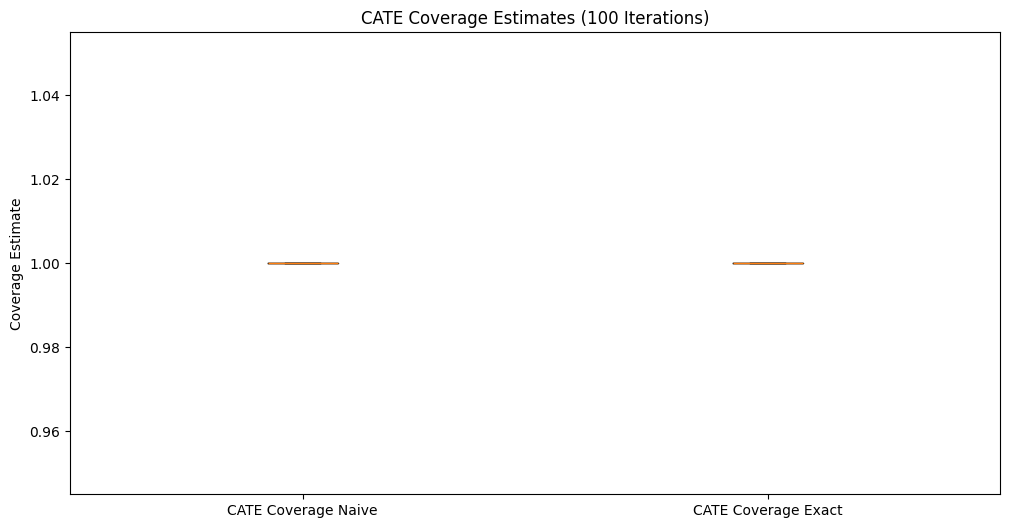

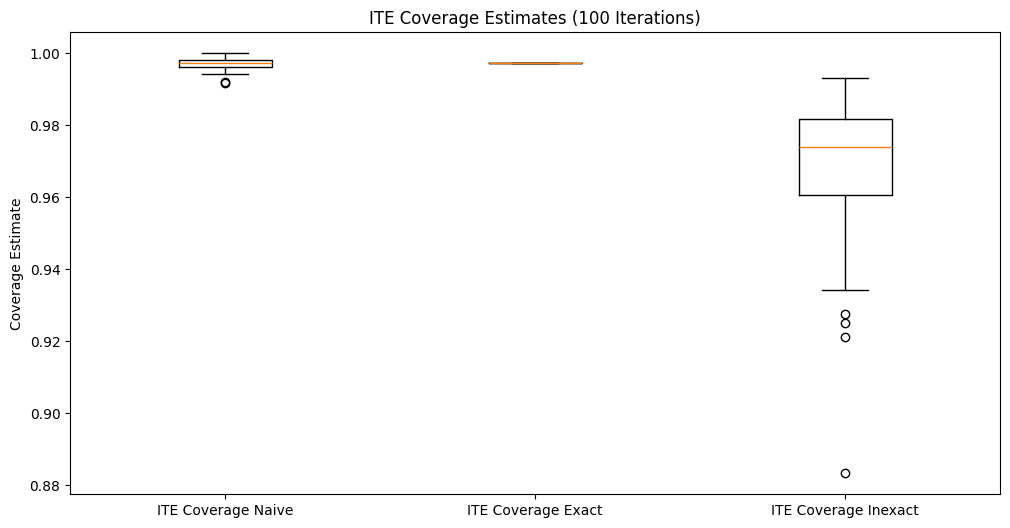

In [12]:
#comparing the results of naive and exact and inexact approaches
import pickle
import matplotlib.pyplot as plt
#open a pickle file containing the results of the inexact approach
inexact_data = pickle.load(open("cate_ite_coverage_inexact.pkl", "rb"))
inexact_ite = inexact_data[inexact_data["method"]=="ite"]["coverage"].to_numpy()
plt.figure(figsize=(12, 6))
plt.boxplot([cate_coverage_estimates_naive, cate_coverage_estimates_exact], labels=[ 'CATE Coverage Naive', 'CATE Coverage Exact'])
plt.title('CATE Coverage Estimates (100 Iterations)')
plt.ylabel('Coverage Estimate')
plt.show()
plt.figure(figsize=(12, 6))
plt.boxplot([ite_coverage_estimates_naive, ite_coverage_estimates_exact,inexact_ite], labels=[ 'ITE Coverage Naive', 'ITE Coverage Exact',"ITE Coverage Inexact"])
plt.title('ITE Coverage Estimates (100 Iterations)')
plt.ylabel('Coverage Estimate')
plt.show()

